In [1]:
## This notebook describes how to use inject noise into timestreams.
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys and inject noise on-the-fly.
## * project back your TOD to sky maps.

In [2]:
## Include the path to the package
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> (systematics) -> TOD2MAP
##################################################################

In [4]:
## Initialise our input maps with no signal...
sky_in = HealpixFitsMap('../s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=3.5, nside_in=512, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()

In [7]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## Firts, we will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct our maps on a 
## sky patch of width 20 deg at a resolution nside = 512.

## MAP2TOD: scan the input sky to generate timestream channel-by-channel.
## this is currently the bottleneck in computation. Need to speed-up this routine!
## Hopefully everything is linear ;-)

## This is where you want to parallelize for big runs, so that different processors 
## (or groups or procs) focus on different scans. Here is the serial version:
nside_out = 512

## Loop over scans
for CESnumber in range(scan.nces):
    
    ## Inject noise with a level (for the array): 30 uK.sqrt(s)
    tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                  projection='healpix', nside_out=nside_out, 
                                  width=130., array_noise_level=30.)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(projection=tod.projection, nside=nside_out, obspix=tod.obspix)
        
    ## Scan input map to get TODs
    d = np.array([
            tod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])
        
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)

100%|██████████| 128/128 [00:11<00:00, 13.09it/s]


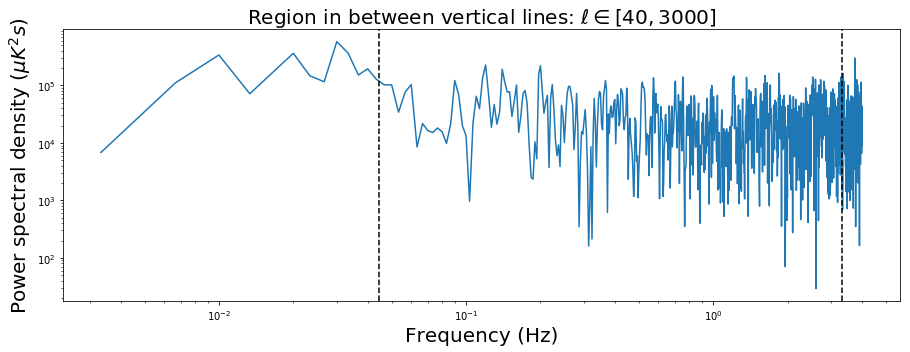

In [8]:
## Let's have a look at the PSD for 5 minutes of observation - all detectors
from s4cmb.tod import psdts

def ell2freq(ell, vscan):
    """
    Rough scaling between timestream frequency and multipole \ell
    given the scan velocity (az speed basically) in deg/s.
    """
    return ell * vscan / 360.

nts = 2400 
for pos, ts in enumerate(d):
    fs, psd = psdts(ts[0:nts], sample_rate=scan.sampling_freq)
    if pos == 0:
        psds = np.zeros_like(psd)
    psds += psd
psds /= (2*tod.npair)

fig = pl.figure(figsize=(15, 5))
pl.loglog(fs, psd)
pl.axvline(ell2freq(40, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.axvline(ell2freq(3000, vscan=scan.sky_speed), 
           ls='--', color='black')
pl.title('Region in between vertical lines: $\ell \in [40, 3000]$', fontsize=20)
pl.xlabel('Frequency (Hz)', fontsize=20)
pl.ylabel('Power spectral density ($\mu K^2 s$)', fontsize=20)
pl.show()

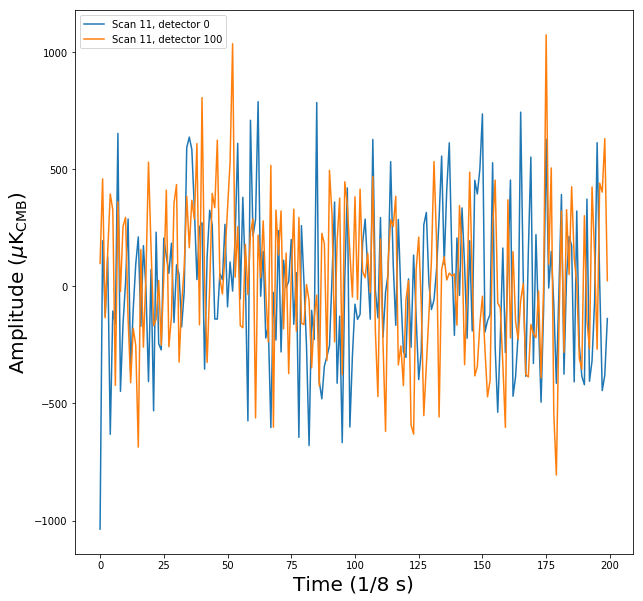

In [9]:
## Let's have a look at some TOD, that is 
## d(t) = I(t) + Q(t)cos(2*theta(t)) + U(t)sin(2*theta(t)).
## Keep in mind we set the sample rate at 8 Hz.
fig = pl.figure(figsize=(10, 10))
pl.plot(d[0][0:200], label='Scan 11, detector 0')
pl.plot(d[100][0:200], label='Scan 11, detector 100')
pl.legend()
pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.show()

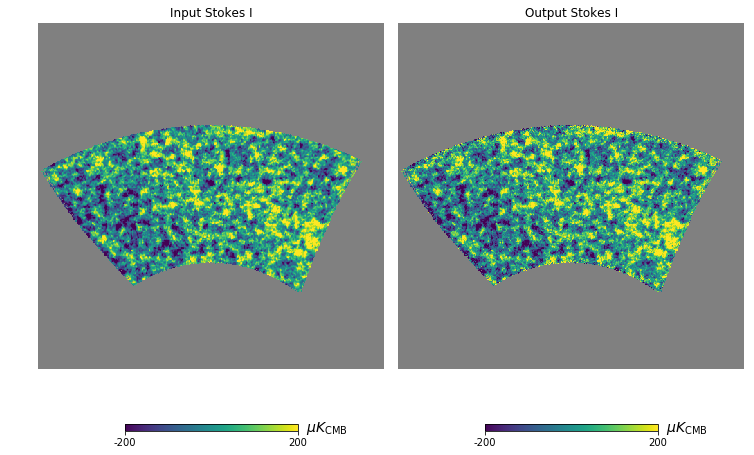

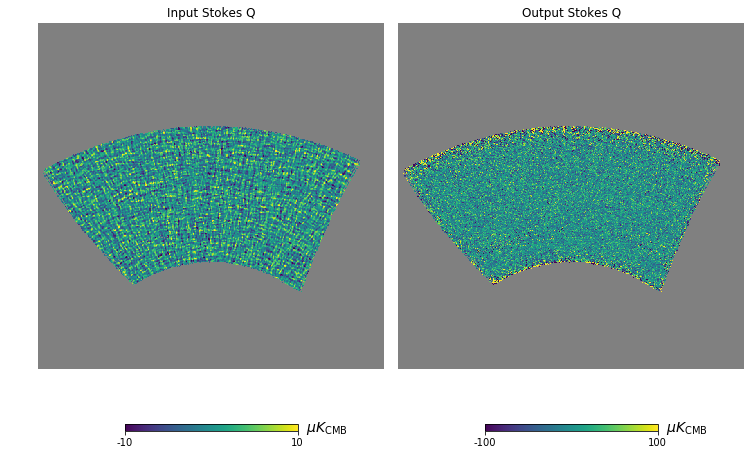

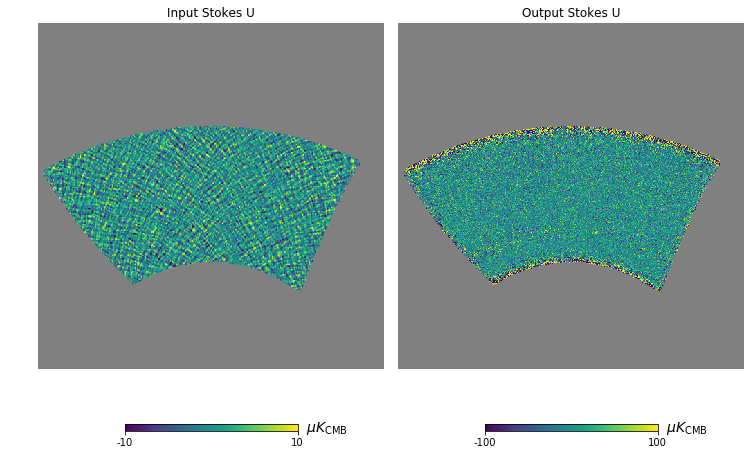

In [12]:
## In the absence of systematics, these operations should not change the 
## signal. Let's check that we did not harm the signal.
xsize = 500
minmax_int = 200
minmax_pol = 100


nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
fig = pl.figure(figsize=(10, 10))
sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

mask = nhit < 1
sky_in.I[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=121, 
            title='Input Stokes I', notext=True, min=-minmax_int, 
            max=minmax_int, unit=r'$\mu K_{\rm CMB}$')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=122, 
            title='Output Stokes I', notext=True, min=-minmax_int, 
            max=minmax_int, unit=r'$\mu K_{\rm CMB}$')
pl.show()

## Stokes Q
fig = pl.figure(figsize=(10, 10))
sky_out = partial2full(sky_out_tot.get_QU()[0], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_in.Q[mask] = np.nan
sky_out[mask] = np.nan

hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=121, 
            unit=r'$\mu K_{\rm CMB}$', notext=True,
            min=-minmax_pol/10., max=minmax_pol/10., title='Input Stokes Q')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=122,
            unit=r'$\mu K_{\rm CMB}$', notext=True,
            min=-minmax_pol, max=minmax_pol, title='Output Stokes Q')
pl.show()

## Stokes U
fig = pl.figure(figsize=(10, 10))
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_in.U[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=121, 
            unit=r'$\mu K_{\rm CMB}$', notext=True, 
            min=-minmax_pol/10., max=minmax_pol/10., title='Input Stokes U')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=122, 
            unit=r'$\mu K_{\rm CMB}$', notext=True, 
            min=-minmax_pol, max=minmax_pol, title='Output Stokes U')
pl.show()

In [11]:
## Notice the change of scale in polarisation! 
## This is the (white) noise level after one scan (4h of observation). 
## Of course you would like eventually to run many scans to decrease the noise level:
## white noise level \propto 1/sqrt(t).